# Temporal difference control

In the previous section, we discussed the temporal difference method way of approximating the value function of a policy. In this section, we cover how temporal difference can help us determine the optimal policy. The idea is similar to that of Monte Carlo control. To determine the optimal policy, we need to estimate the state action value function. In a temporal difference setup, the update rule is given by 

$$Q(\mathbf{s}_t, \mathbf{a}_t) \leftarrow Q(\mathbf{s}_t, \mathbf{a}_t) + \alpha \cdot [r_t + \gamma Q(\mathbf{s}_{t+1}, \mathbf{a}_{t+1}) - Q(\mathbf{s}_{t}, \mathbf{a}_{t})]$$

Which leads to the following algorithm known as SARSA (since each iteration uses a $(\mathbf{s}_t, \mathbf{a}_t, r_t, \mathbf{s}_{t+1}, \mathbf{a}_{t+1})$ sample). 

## SARSA

```{prf:algorithm} SARSA
:label: my-algorithm

**Inputs** Learning rate $\alpha, \epsilon \in (0, 1)$

**Output** Estimated policy $\pi(\mathbf{a}|\mathbf{s})$

1. Initialize $Q(s, a)$ arbitrary for all $s\in \mathcal{S}, a\in \mathcal{A}$ expect for terminal states
2. For each episode
	1. Initialize state $\mathbf{s}_0$
	2. While not terminate
		1. Choose $\mathbf{a}_t$ from current $Q$ function estimate with $\epsilon$-greedy strategy.
		2. Take action $\mathbf{a}_t$, observe $r_t, \mathbf{s}_{t+1}$
        3. Choose $\mathbf{a}_{t+1}$ from current $Q$ function estimate with $\epsilon$-greedy strategy.
        3. Update $Q(\mathbf{s}_t, \mathbf{a}_t) \leftarrow Q(\mathbf{s}_t, \mathbf{a}_t) + \alpha \cdot [r_t + \gamma Q(\mathbf{s}_{t+1}, \mathbf{a}_{t+1}) - Q(\mathbf{s}_{t}, \mathbf{a}_{t})]$
```

Below, we implement SARSA to determine the policy for the cliff-walking environment. 

In [1]:
import gym
import numpy as np
import time
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from td import *

In [2]:
def SARSA(env: any, policy: Policy, n_episodes: int, gamma: float, alpha: float, max_steps: int=1000):
    """
    Implementation of sarsa algorithm 
    @return q_values: The learned action values of the form
        {state1: {action1: q11, action2: q12,...},
         state2: {action1: q21, action2: q22,...}}
    """
    states = policy.states
    actions = policy.actions
    q_values = {state: {action: 0 for action in actions} for state in states}
    for episode in range(n_episodes):
        state = env.reset()[0]
        action = policy.get_action(state, q_values)
        done = False
        step_count = 0
        cum_reward = 0
        while not done and step_count < max_steps:
            new_state, reward, done, info = env.step(action)[:4]
            new_action = policy.get_action(new_state, q_values)
            q_values[state][action] += alpha * (reward + gamma * q_values[new_state][new_action] - q_values[state][action])
            state = new_state
            action = new_action
            done = reward == -100
            if state == 47:
                reward, done = 10, True
            step_count += 1
            cum_reward += reward * gamma ** step_count
    return q_values

In [3]:
class LearnedPolicy(Policy):
    """
    Policy that implements epsilon greedy algorithm
    """
    def get_action(self, state, q_values, epsilon=0.1):
        action_values = q_values[state] 
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)
        return max(action_values, key=action_values.get)

In [35]:
env = gym.make('CliffWalking-v0')
states = list(range(env.observation_space.n))
actions = list(range(env.action_space.n))
policy = LearnedPolicy(states, actions)
q_values = SARSA(env, policy, 3000, 1, 0.1, 500)

We ran SARSA for around $3000$ epochs with learning rate $\alpha=0.1$ and $\epsilon=0.1$. The discount factor is set to be $1$. The estimated policy is shown in the figure below. As we can see, the estimated policy move away from states closing to the cliff and prefers the path that is longer but safer.

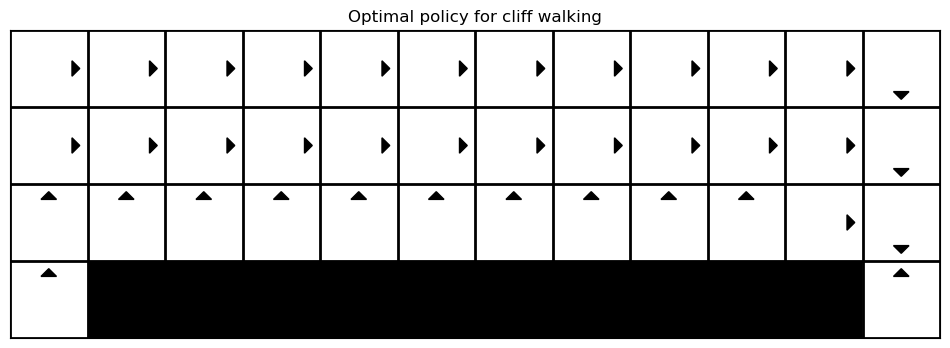

In [36]:
display_policy(policy, q_values)

## Q-Learning

SARSA is an on policy temporal difference method, since we are modifying the policy in place while training. An offline version of temporal difference control is proposed in 1989 by Watkins. The algorithm is known as Q-learning. Instead of using the bootstrapped estimate of future value, Q learning updates the state action function as follows

$$Q(\mathbf{s}_t, \mathbf{a}_t) \leftarrow Q(\mathbf{s}_t, \mathbf{a}_t) + \alpha \cdot [r_t + \gamma \max_{\mathbf{a}\in \mathcal{A}} Q(\mathbf{s}_{t+1}, \mathbf{a}) - Q(\mathbf{s}_{t}, \mathbf{a}_{t})]$$

Note that this is an offline method because we generate the samples using an $\epsilon$-greedy method but updates our estimate using the greedy policy

$$\hat{\pi}(\mathbf{a}|\mathbf{s}) = \underset{\mathbf{a}\in \mathcal{A}}{\text{argmax}}\; Q(\mathbf{s}_{t+1}, \mathbf{a})$$

The psuedocode for Q learning is provided below

```{prf:algorithm} Q-learning
:label: my-algorithm

**Inputs** Learning rate $\alpha, \epsilon \in (0, 1)$

**Output** Estimated policy $\pi(\mathbf{a}|\mathbf{s})$

1. Initialize $Q(s, a)$ arbitrary for all $s\in \mathcal{S}, a\in \mathcal{A}$ expect for terminal states
2. For each episode
	1. Initialize state $\mathbf{s}_0$
	2. While not terminate
		1. Choose $\mathbf{a}_t$ from current $Q$ function estimate with $\epsilon$-greedy strategy.
		2. Take action $\mathbf{a}_t$, observe $r_t, \mathbf{s}_{t+1}$
        3. Choose $\mathbf{a}_{t+1}$ from current $Q$ function estimate with $\epsilon$-greedy strategy.
        3. Update $Q(\mathbf{s}_t, \mathbf{a}_t) \leftarrow Q(\mathbf{s}_t, \mathbf{a}_t) + \alpha \cdot [r_t + \gamma \max_{\mathbf{a}\in \mathcal{A}} Q(\mathbf{s}_{t+1}, \mathbf{a}) - Q(\mathbf{s}_{t}, \mathbf{a}_{t})]$
```

Below we implement and tested Q learning on the cliff walking enviroment. We ran it for around $3000$ episodes following the same setting as SARSA. 

In [17]:
def Q_Learning(env: any, policy: Policy, n_episodes: int, gamma: float, alpha: float, max_steps: int=1000):
    """
    Implementation of Q-Learning algorithm
    @return q_values: The learned action values of the form
        {state1: {action1: q11, action2: q12,...},
         state2: {action1: q21, action2: q22,...}}
    """
    states = policy.states
    actions = policy.actions
    q_values = {state: {action: 0 for action in actions} for state in states}
    for episode in range(n_episodes):
        state = env.reset()[0]
        action = policy.get_action(state, q_values)
        done = False
        step_count = 0
        while not done and step_count < max_steps:
            new_state, reward, done, info = env.step(action)[:4]
            new_action = policy.get_action(new_state, q_values)
            q_values[state][action] += alpha * (reward + gamma * max(q_values[new_state].values()) - q_values[state][action])
            state = new_state
            action = new_action
            done = reward == -100
            if state == 47:
                reward, done = 10, True
            step_count += 1
    return q_values

In [39]:
states = list(range(env.observation_space.n))
actions = list(range(env.action_space.n))
policy = LearnedPolicy(states, actions)

q_values = Q_Learning(env, policy, 10000, 1, 0.1, 500)

Note the difference between the estimated policy between SARSA and Q-learning. SARSA learns a conservative solution—it chooses a solution that is safer (i.e. far away from cliff), but takes more timestep to complete. Q-learning on the other hand, learns a more risky solution. It uses less timestep but risk falling into the cliff. One explanation is that Q-learning learns thorough taking greedy actions. 

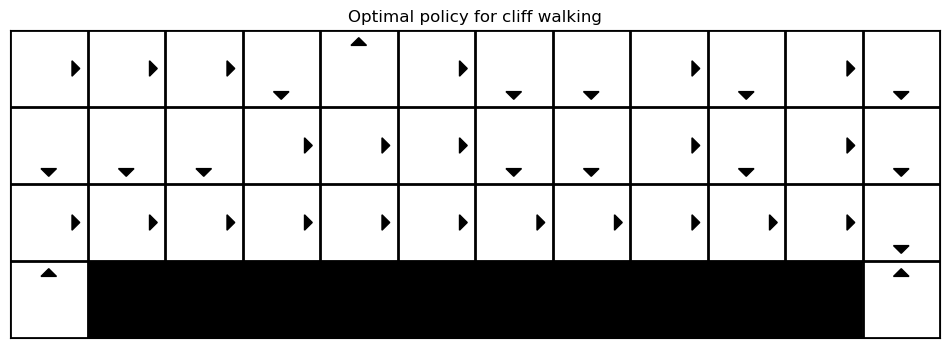

In [40]:
display_policy(policy, q_values)